# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Statements

In [ ]:
import requests
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Query Endpoint

In [ ]:
def get_unixtime(date):
  date = date.split('/')
  d = int(date[1])
  m = int(date[0])
  y = int(date[2])
  dt = datetime.datetime(y, m, d)
  timestamp = int(dt.replace(tzinfo=datetime.timezone.utc).timestamp())
  return timestamp

In [ ]:
base_url = 'http://history.openweathermap.org/data/2.5/history/city?q={city_ID},{country_code}&type=hour&start={start}&end={end}&appid={API_key}'
city_ID = 'New York'
country_code = 'US'
start_dates = ['8/1/2021', '8/8/2021', '8/15/2021', '8/22/2021', '8/29/2021', '9/5/2021', '9/12/2021', '9/19/2021', '9/26/2021']
end_dates = ['8/8/2021', '8/15/2021', '8/22/2021', '8/29/2021', '9/5/2021', '9/12/2021', '9/19/2021', '9/26/2021', '10/1/2021']
API_key = 'ef6ddee6892b12ba38286ddd78dfe020'

api_endpoints = {}

for start, end in zip(start_dates, end_dates):
  dates = start + '-' + end
  api_endpoints[dates] = base_url.format(city_ID=city_ID, country_code=country_code, start=get_unixtime(start), end=get_unixtime(end), API_key=API_key)

In [ ]:
weather_data = {}

for start, end in zip(start_dates, end_dates):
  dates = start + '-' + end
  api_endpoint = api_endpoints[dates]
  weather_data[dates] = requests.get(api_endpoint).json()

# Parse Response

In [ ]:
dt_cols = ['dt']
main_cols = ['temp', 'feels_like', 'pressure', 'humidity', 'temp_min', 'temp_max', 'sea_level', 'grnd_level']
wind_cols = ['speed', 'deg', 'gust']
clouds_cols = ['all']
rain_cols = ['1h', '3h']
snow_cols = ['1h', '3h']
weather_cols = ['id', 'main', 'description', 'icon']

col_groups = {'dt':dt_cols, 'main':main_cols, 'wind':wind_cols, 'clouds': clouds_cols, 'rain':rain_cols, 'snow':snow_cols, 'weather':weather_cols}

In [ ]:
weather_df = {}

for start, end in zip(start_dates, end_dates):
  dates = start + '-' + end
  hours = weather_data[dates]['list']
  for hour in hours:
    for col_group in col_groups:
      cols = col_groups[col_group]
      for col in cols:
        col_name = col_group + '/' + col
        if col_name not in weather_df:
          weather_df[col_name] = []
          if col_group == 'dt':
            try:
              data = hour['dt']
            except KeyError:
              data = np.nan
          elif col_group == 'weather':
            try:
              data = hour['weather'][0][col]
            except KeyError:
              data = np.nan
          else:
            try:
              data = hour[col_group][col]
            except KeyError:
              data = np.nan
        else:
          if col_group == 'dt':
            try:
              data = hour['dt']
            except KeyError:
              data = np.nan
          elif col_group == 'weather':
            try:
              data = hour['weather'][0][col]
            except KeyError:
              data = np.nan
          else:
            try:
              data = hour[col_group][col]
            except KeyError:
              data = np.nan
        weather_df[col_name].append(data)

# Clean Data

In [ ]:
weather_df = pd.DataFrame(weather_df)
weather_df.isna().sum()

dt/dt                     0
main/temp                 0
main/feels_like           0
main/pressure             0
main/humidity             0
main/temp_min             0
main/temp_max             0
main/sea_level         1473
main/grnd_level        1473
wind/speed                0
wind/deg                  0
wind/gust               723
clouds/all                0
rain/1h                1383
rain/3h                1473
snow/1h                1473
snow/3h                1473
weather/id                0
weather/main              0
weather/description       0
weather/icon              0
dtype: int64

In [ ]:
weather_df = weather_df.drop(['main/temp_min', 'main/temp_max', 'main/sea_level', 'main/grnd_level', 'rain/3h', 'snow/1h', 'snow/3h', 'weather/icon'], axis=1) # drop missing / irrelevant cols
weather_df.head()

,dt/dt,main/temp,main/feels_like,main/pressure,main/humidity,wind/speed,wind/deg,wind/gust,clouds/all,rain/1h,weather/id,weather/main,weather/description
0,1627776000,295.99,295.56,1013,47,0.45,319,1.34,1,NaN,800,Clear,clear sky
1,1627779600,294.52,294.04,1014,51,0.45,324,1.34,1,NaN,800,Clear,clear sky
2,1627783200,293.70,293.22,1014,54,0.00,0,NaN,1,NaN,800,Clear,clear sky
3,1627786800,293.04,292.65,1014,60,1.34,334,2.24,1,NaN,800,Clear,clear sky
4,1627790400,292.66,292.47,1014,69,1.54,240,NaN,1,NaN,800,Clear,clear sky


In [ ]:
# https://openweathermap.org/weather-data for info on data fields/units...

# unix epoch to datetime
datetime_series = pd.to_datetime(weather_df['dt/dt'], unit='s') 

# datetime to datetimeindex
datetime_index = pd.DatetimeIndex(datetime_series.values)
datetime_index = datetime_index.tz_localize(tz='US/Eastern') # eastern timezone
weather_df = weather_df.set_index(datetime_index)
weather_df = weather_df.drop('dt/dt', axis=1)

# replace missing gust, rain data w/ 0
weather_df['wind/gust'] = weather_df['wind/gust'].fillna(0)
weather_df['rain/1h'] = weather_df['rain/1h'].fillna(0)

# K to C
weather_df['main/temp'] = weather_df['main/temp'] - 273.15
weather_df['main/feels_like'] = weather_df['main/feels_like'] - 273.15

# # K to F
# weather_df['main/temp'] = (weather_df['main/temp'] - 273.15) * (9 / 5) + 32 
# weather_df['main/feels_like'] = (weather_df['main/feels_like'] - 273.15) * (9 / 5) + 32

# # m/s to mi/hr
# weather_df['wind/speed'] = weather_df['wind/speed'] * 2.237 
# weather_df['wind/gust'] = weather_df['wind/gust'] * 2.237

# # mm to in
# weather_df['rain/1h'] = weather_df['rain/1h'] / 25.4 

# # filter df for 6AM-9PM monday-friday
# weather_df_mf69 = weather_df.copy()
# weather_df_mf69 = weather_df_mf69[weather_df_mf69.index.dayofweek.isin([1,2,3,4,5])]
# weather_df_mf69 = weather_df_mf69.between_time('06:00', '21:00')

In [ ]:
weather_df.head()

,main/temp,main/feels_like,main/pressure,main/humidity,wind/speed,wind/deg,wind/gust,clouds/all,rain/1h,weather/id,weather/main,weather/description
2021-08-01 00:00:00-04:00,22.84,22.41,1013,47,0.45,319,1.34,1,0.0,800,Clear,clear sky
2021-08-01 01:00:00-04:00,21.37,20.89,1014,51,0.45,324,1.34,1,0.0,800,Clear,clear sky
2021-08-01 02:00:00-04:00,20.55,20.07,1014,54,0.00,0,0.00,1,0.0,800,Clear,clear sky
2021-08-01 03:00:00-04:00,19.89,19.50,1014,60,1.34,334,2.24,1,0.0,800,Clear,clear sky
2021-08-01 04:00:00-04:00,19.51,19.32,1014,69,1.54,240,0.00,1,0.0,800,Clear,clear sky


In [ ]:
# # save weather_df to drive as csv
# weather_df.to_csv('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Weather/owm_weather_data.csv')

# EDA

In [ ]:
dt = weather_df.index
temp_act = weather_df['main/temp']
temp_feel = weather_df['main/feels_like']
wind = weather_df['wind/speed']
gust = weather_df['wind/gust']
rain = weather_df['rain/1h']

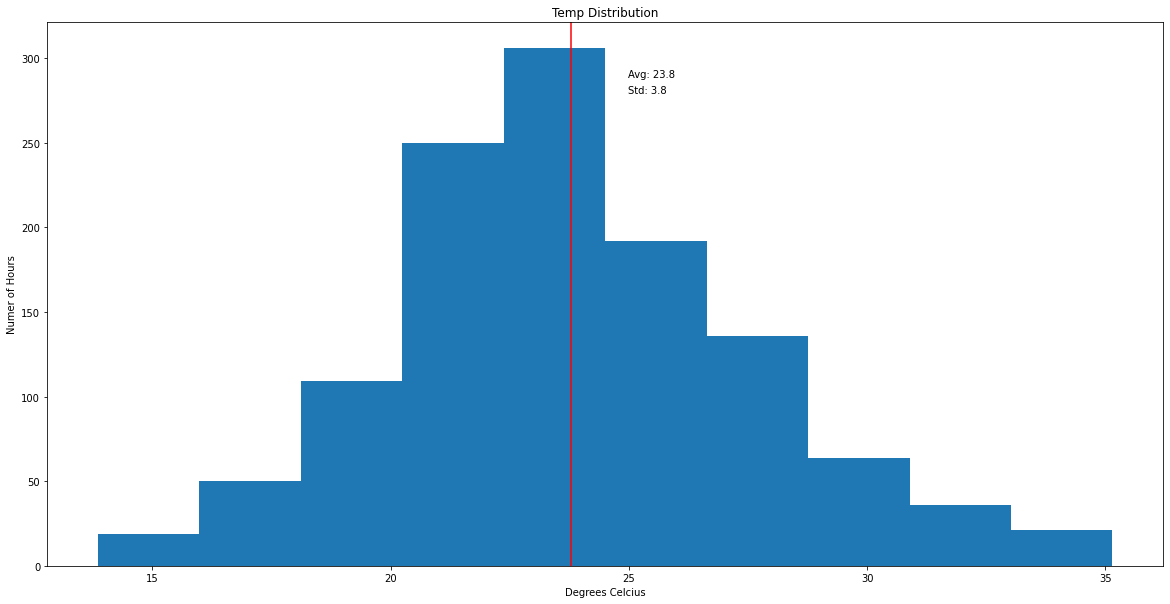

In [ ]:
data = np.array(temp_act)
data_avg = data.mean()
data_std = data.std()
plt.figure(figsize=(20, 10))
plt.hist(data)
plt.axvline(data_avg, color='red')
min_ylim, max_ylim = plt.ylim()
plt.text(data_avg*1.05, max_ylim*0.90, f'Avg: {data_avg:.1f}')
plt.text(data_avg*1.05, max_ylim*0.87, f'Std: {data_std:.1f}')
plt.xlabel('Degrees Celcius')
plt.ylabel('Numer of Hours')
plt.title('Temp Distribution')
plt.show()

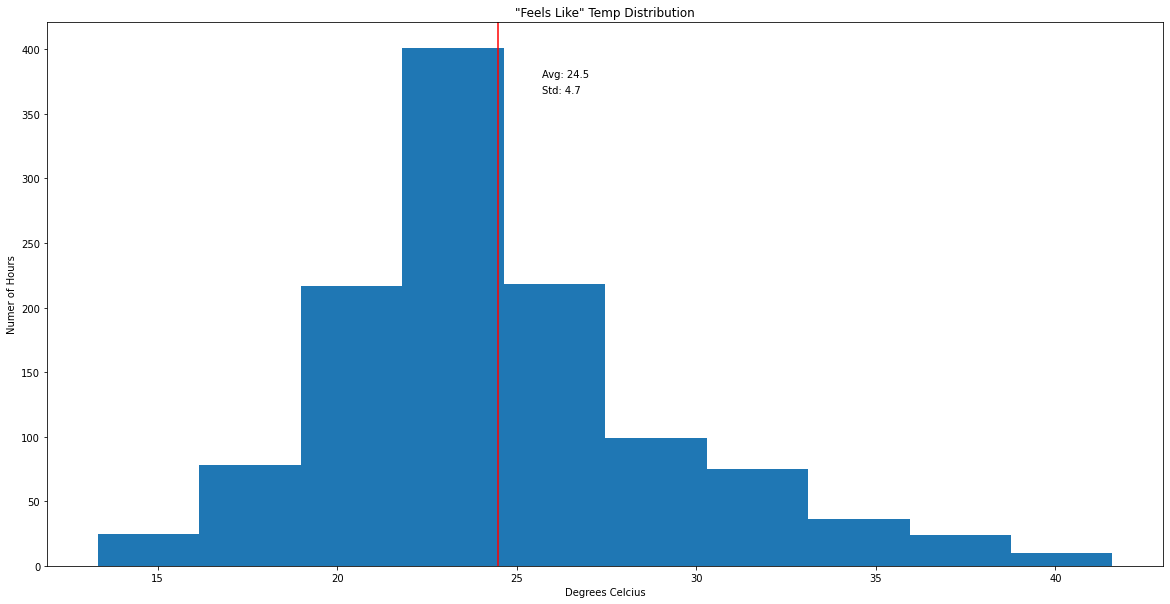

In [ ]:
data = np.array(temp_feel)
data_avg = data.mean()
data_std = data.std()
plt.figure(figsize=(20, 10))
plt.hist(data)
plt.axvline(data_avg, color='red')
min_ylim, max_ylim = plt.ylim()
plt.text(data_avg*1.05, max_ylim*0.90, f'Avg: {data_avg:.1f}')
plt.text(data_avg*1.05, max_ylim*0.87, f'Std: {data_std:.1f}')
plt.xlabel('Degrees Celcius')
plt.ylabel('Numer of Hours')
plt.title('"Feels Like" Temp Distribution')
plt.show()

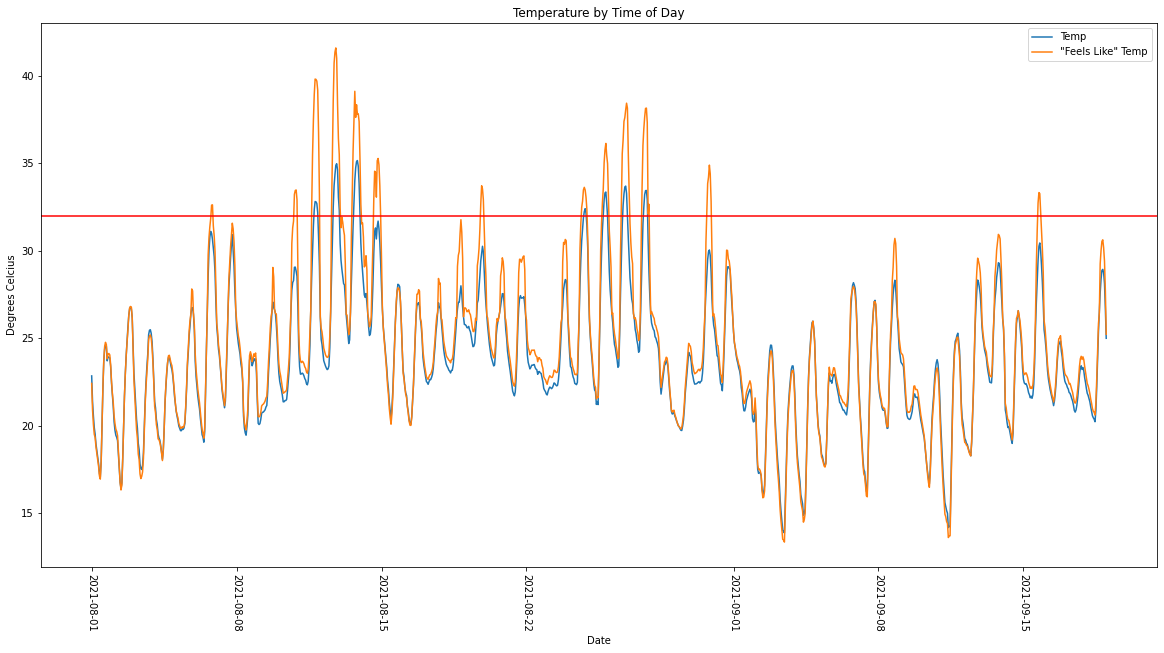

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(dt, temp_act, label='Temp')
plt.plot(dt, temp_feel, label='"Feels Like" Temp')
plt.axhline(y=32, color='red')
plt.xticks(rotation=270)
plt.xlabel('Date')
plt.ylabel('Degrees Celcius')
plt.title('Temperature by Time of Day')
plt.legend()
plt.show()

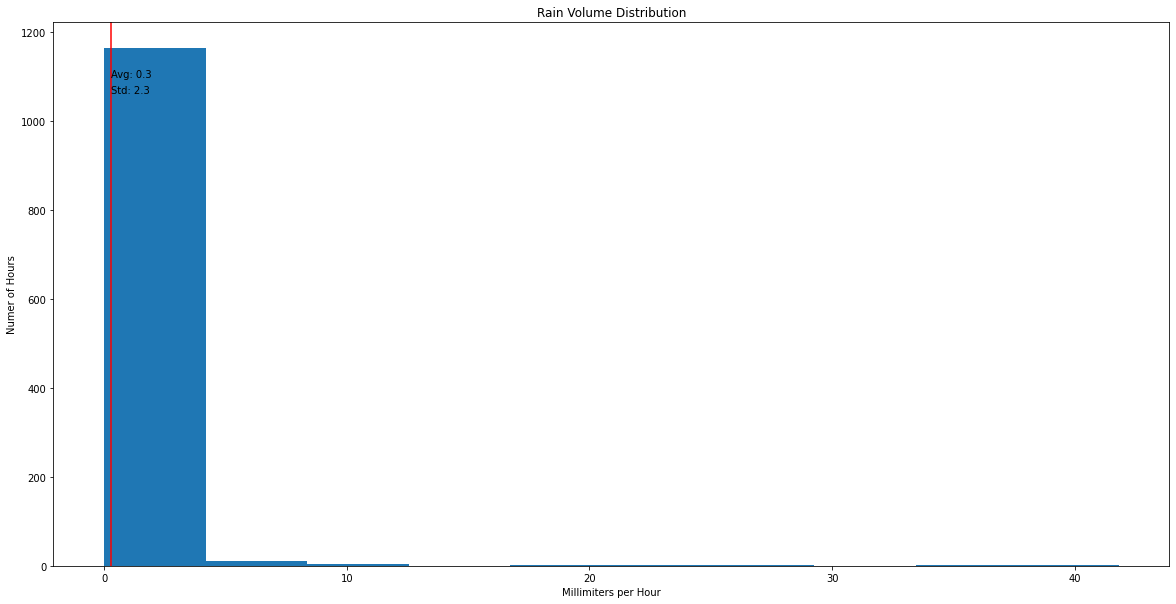

In [ ]:
data = np.array(rain)
data_avg = data.mean()
data_std = data.std()
plt.figure(figsize=(20, 10))
plt.hist(data)
plt.axvline(data_avg, color='red')
min_ylim, max_ylim = plt.ylim()
plt.text(data_avg*1.05, max_ylim*0.90, f'Avg: {data_avg:.1f}')
plt.text(data_avg*1.05, max_ylim*0.87, f'Std: {data_std:.1f}')
plt.xlabel('Millimiters per Hour')
plt.ylabel('Numer of Hours')
plt.title('Rain Volume Distribution')
plt.show()

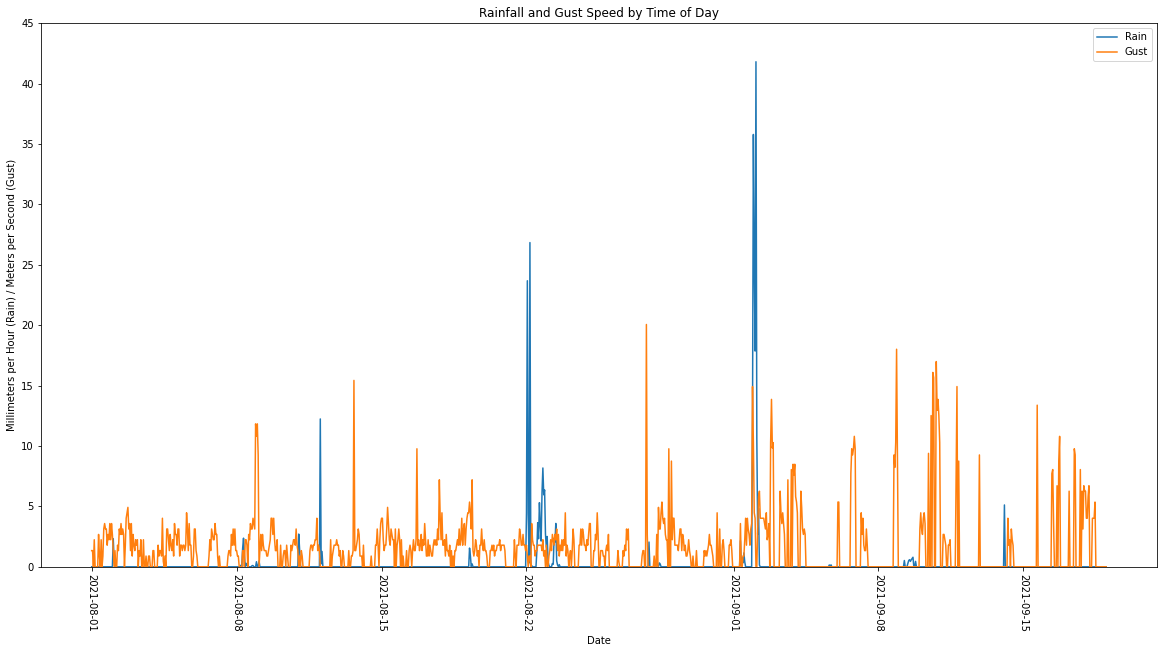

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(dt, rain, label='Rain')
plt.plot(dt, gust, label='Gust')
plt.xticks(rotation=270)
plt.xlabel('Date')
plt.ylabel('Millimeters per Hour (Rain) / Meters per Second (Gust)')
plt.ylim([0,45])
plt.title('Rainfall and Gust Speed by Time of Day')
plt.legend()
plt.show()

In [ ]:
dates_seen = set()
dates = []

for date in weather_df.index.date:
  if date not in dates_seen:
    dates_seen.add(date)
    dates.append(date)
dates.pop()

temp_by_time = {}
temp_by_time_feel = {}

times = list(range(6, 24, 3))

for time in times:
  filtered = weather_df[weather_df.index.hour == time]
  temp_by_time[time] = list(filtered['main/temp'])
  temp_by_time_feel[time] = list(filtered['main/feels_like'])

hot_hrs_by_day = []
hot_hrs_by_day_feel = []
rain_hrs_by_day = []
heavy_rain_hrs_by_day = []

days = list(range(0, 7, 1))
days_of_week = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']

for day in days:
  filtered = weather_df[weather_df.index.dayofweek == day]
  hot_hrs_by_day.append(filtered[filtered['main/temp'] >= 32].shape[0])
  hot_hrs_by_day_feel.append(filtered[filtered['main/feels_like'] >= 32].shape[0])
  rain_hrs_by_day.append(filtered[filtered['rain/1h'] > 0].shape[0])
  heavy_rain_hrs_by_day.append(filtered[filtered['rain/1h'] >= 4].shape[0]) # https://water.usgs.gov/edu/activity-howmuchrain-metric.html#:~:text=Heavy%20rain%3A%20Greater%20than%204,than%2010%20mm%20per%20hour.

rain_hrs_by_hr = []
heavy_rain_hrs_by_hr = []

hours = list(range(0, 24, 1))

for hour in hours:
  filtered = weather_df[weather_df.index.hour == hour]
  rain_hrs_by_hr.append(filtered[filtered['rain/1h'] > 0].shape[0])
  heavy_rain_hrs_by_hr.append(filtered[filtered['rain/1h'] >= 4].shape[0]) # https://water.usgs.gov/edu/activity-howmuchrain-metric.html#:~:text=Heavy%20rain%3A%20Greater%20than%204,than%2010%20mm%20per%20hour.

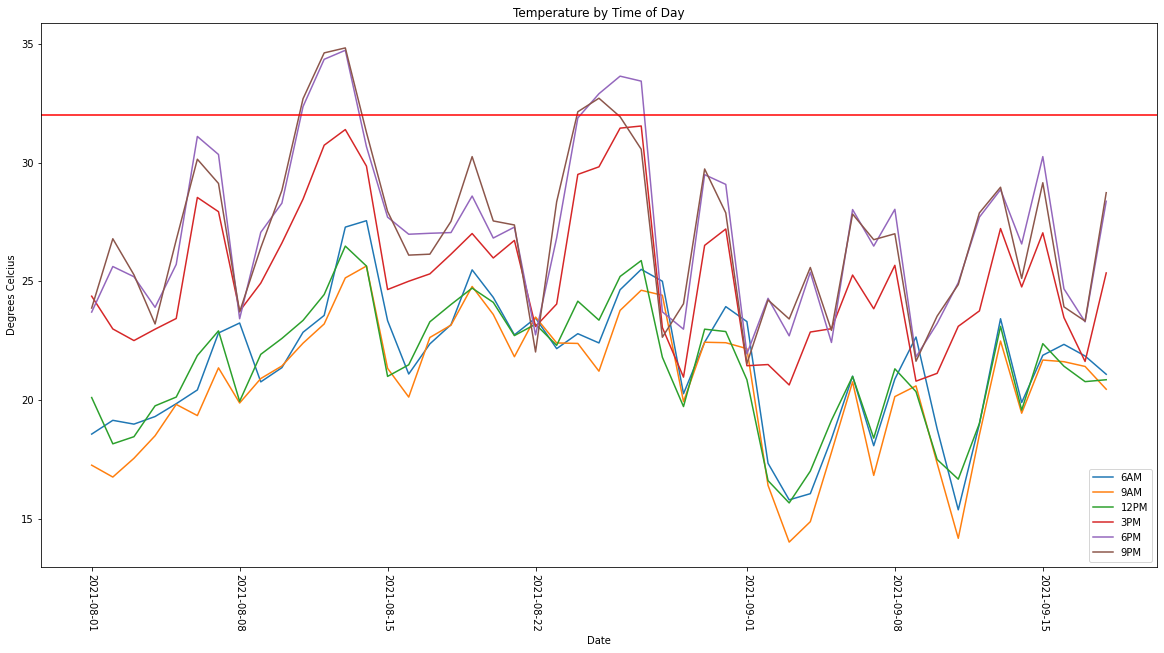

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(dates, temp_by_time[6], label='6AM')
plt.plot(dates, temp_by_time[9], label='9AM')
plt.plot(dates, temp_by_time[12], label='12PM')
plt.plot(dates, temp_by_time[15], label='3PM')
plt.plot(dates, temp_by_time[18], label='6PM')
plt.plot(dates, temp_by_time[21], label='9PM')
plt.axhline(y=32, color='red')
plt.xticks(rotation=270)
plt.xlabel('Date')
plt.ylabel('Degrees Celcius')
plt.title('Temperature by Time of Day')
plt.legend()
plt.show()

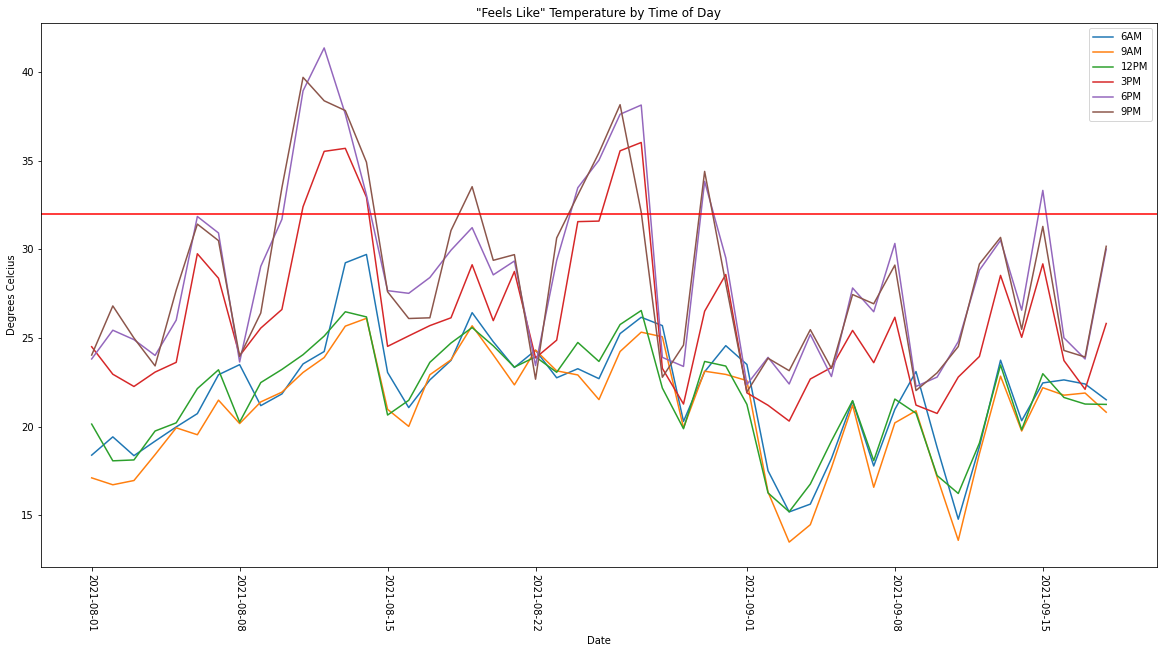

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(dates, temp_by_time_feel[6], label='6AM')
plt.plot(dates, temp_by_time_feel[9], label='9AM')
plt.plot(dates, temp_by_time_feel[12], label='12PM')
plt.plot(dates, temp_by_time_feel[15], label='3PM')
plt.plot(dates, temp_by_time_feel[18], label='6PM')
plt.plot(dates, temp_by_time_feel[21], label='9PM')
plt.axhline(y=32, color='red')
plt.xticks(rotation=270)
plt.xlabel('Date')
plt.ylabel('Degrees Celcius')
plt.title('"Feels Like" Temperature by Time of Day')
plt.legend()
plt.show()

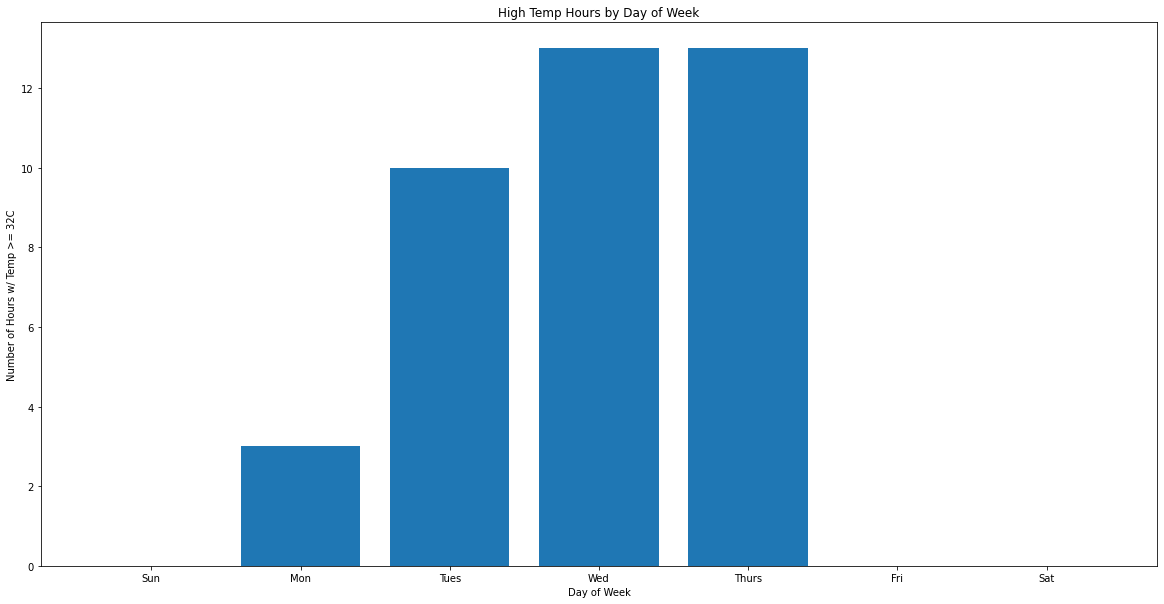

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(x=days, height=hot_hrs_by_day)
plt.xticks(days, days_of_week)
plt.xlabel('Day of Week')
plt.ylabel('Number of Hours w/ Temp >= 32C')
plt.title('High Temp Hours by Day of Week')
plt.show()

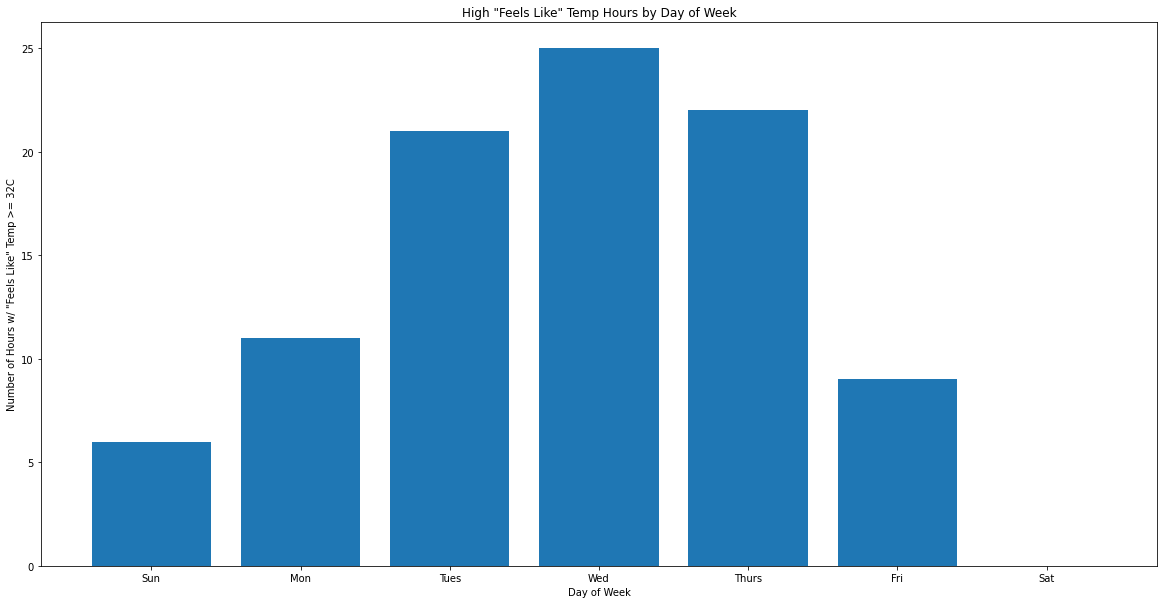

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(x=days, height=hot_hrs_by_day_feel)
plt.xticks(days, days_of_week)
plt.xlabel('Day of Week')
plt.ylabel('Number of Hours w/ "Feels Like" Temp >= 32C')
plt.title('High "Feels Like" Temp Hours by Day of Week')
plt.show()

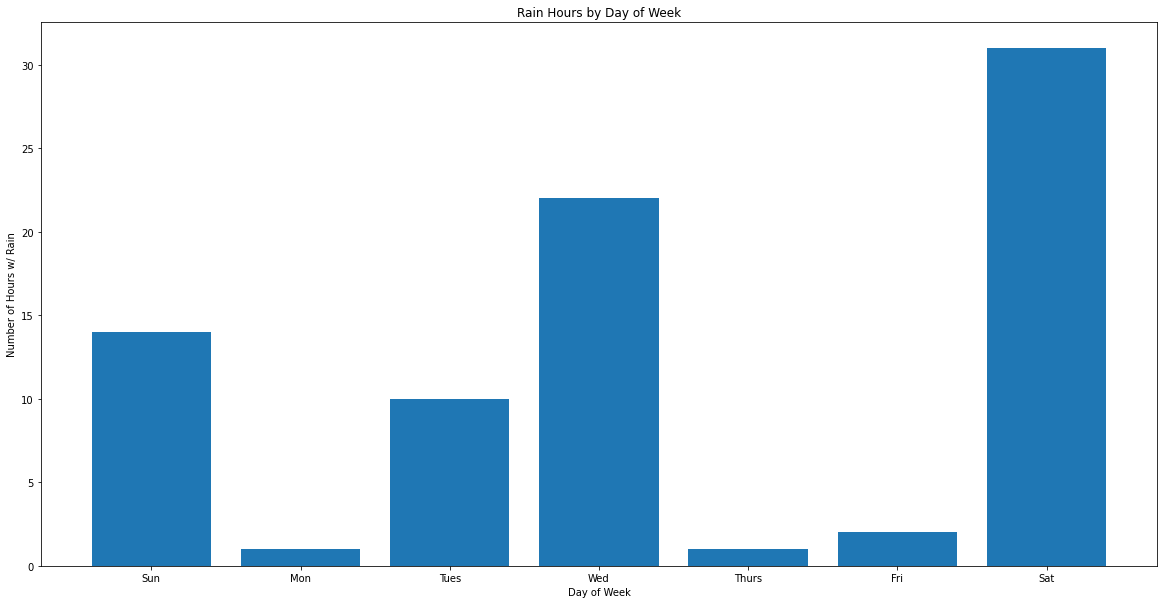

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(x=days, height=rain_hrs_by_day)
plt.xticks(days, days_of_week)
plt.xlabel('Day of Week')
plt.ylabel('Number of Hours w/ Rain')
plt.title('Rain Hours by Day of Week')
plt.show()

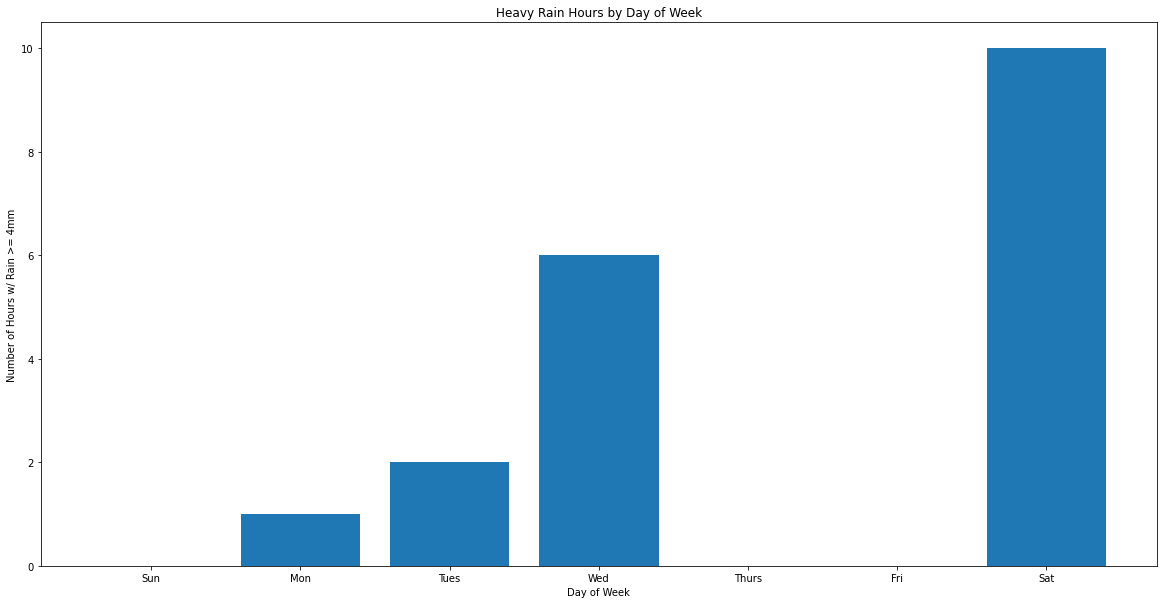

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(x=days, height=heavy_rain_hrs_by_day)
plt.xticks(days, days_of_week)
plt.xlabel('Day of Week')
plt.ylabel('Number of Hours w/ Rain >= 4mm')
plt.title('Heavy Rain Hours by Day of Week')
plt.show()

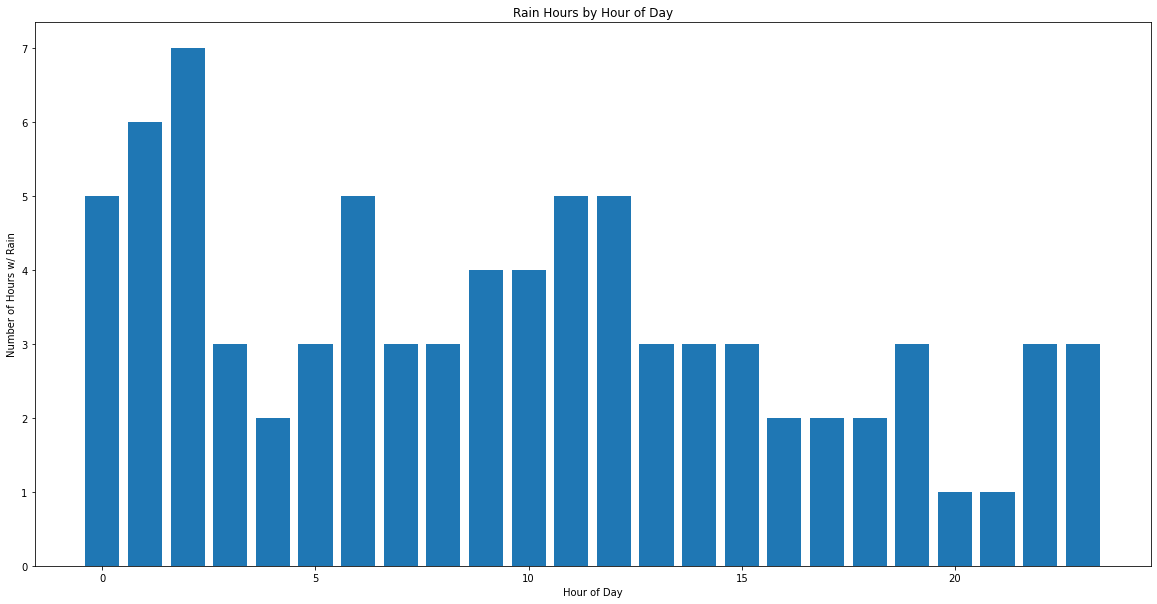

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(x=hours, height=rain_hrs_by_hr)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Hours w/ Rain')
plt.title('Rain Hours by Hour of Day')
plt.show()

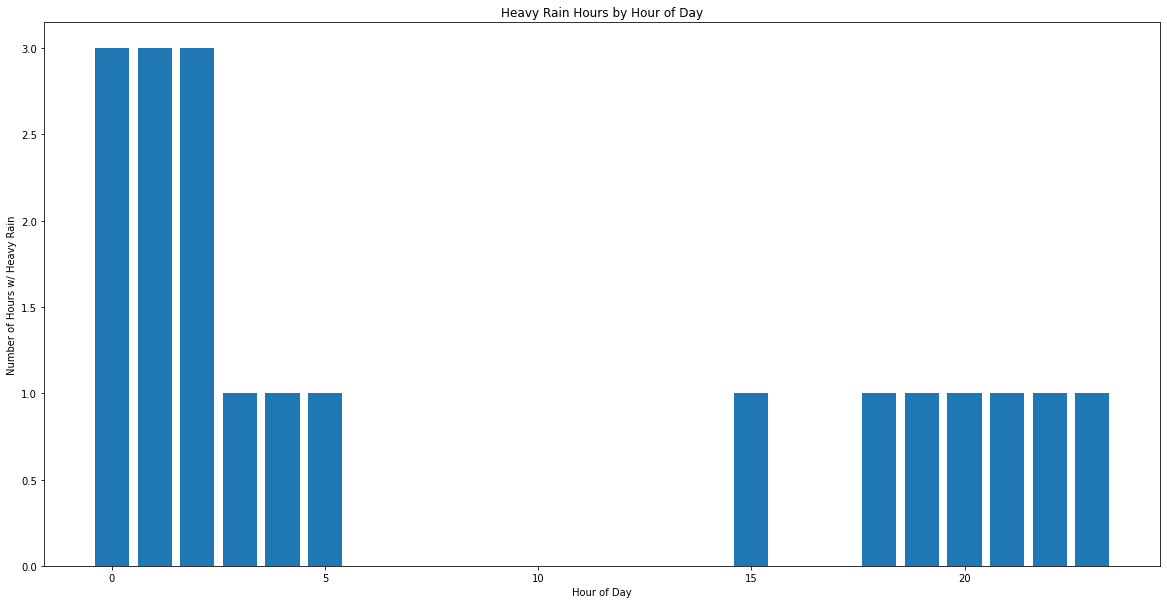

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(x=hours, height=heavy_rain_hrs_by_hr)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Hours w/ Heavy Rain')
plt.title('Heavy Rain Hours by Hour of Day')
plt.show()